# <center>1. Introduction </center>

### This example demonstrates performing the following tasks using portpy:

1. Query the existing patients in the database
    (you first need to download the patient database from the link provided in the GitHub page).
2. Query the data provided for a specified patient in the database.
3. Create a simple IMRT plan using CVXPy package. You can call different opensource/commercial optimization engines
    from CVXPy,but you first need to download them and obtain an appropriate license.
    Most commercial optimization engines (e.g., Mosek, Gorubi) give free academic license if you have .edu email
    address
4. Visualise the plan (dose_1d distribution, fluence)
5. Evaluate the plan based on some clinically relevant metrics


In [1]:
!pip install portpy-photon

In [2]:
import portpy_photon as pp
pp.__version__

'0.0.2'

In [2]:
# specify the patient data location
# (you first need to download the patient database from the link provided in the GitHub page)
data_dir = r'F:\Research\Data_newformat\Python-PORT\Data'
# display the existing patients. To display it in browser rather than console, turn on in_browser=True
pp.Visualize.display_patients(data_dir=data_dir)

,patient_id,disease_site,ptv_vol_cc,num_beams,iso_center_shift
0,Lung_Patient_1,Lung,737.229,72,No


In [3]:
# pick a patient from the existing patient list to get detailed info about the patient data (e.g., beams_dict, structures, )
patient_id = 'Lung_Patient_1'
pp.Visualize.display_patient_metadata(patient_id, data_dir=data_dir)

Beams table..


,ID,gantry_angle,collimator_angle,couch_angle,beam_modality,energy_MV,influence_matrix(sparse/full),iso_center,MLC_name,machine_name
0,0,0,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
1,1,5,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
2,2,10,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
3,3,15,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
4,4,20,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
5,5,25,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
6,6,30,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
7,7,35,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
8,8,40,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
9,9,45,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM


Structure table..


,name,volume_cc
0,GTV,356.987
1,PTV,737.229
2,ESOPHAGUS,54.889
3,HEART,1069.187
4,LUNG_L,1969.534
5,LUNG_R,1890.890
6,CORD,63.291
7,SKIN,1.000


### Create plan
Create my_plan object for the planner beams.

For the customized beams_dict, you can pass the argument beam_ids
e.g. my_plan = pp.Plan(patient_name, beam_ids=[0,1,2,3,4,5,6])


In [4]:
my_plan = pp.Plan(patient_id, data_dir=data_dir)

Creating BEV..
Loading sparse influence matrix...
Done


### Run Optimization
- Run imrt fluence map optimization using cvxpy and one of the supported solvers and save the optimal solution in sol dictionary
- CVXPy supports several opensource (ECOS, OSQP, SCS) and commercial solvers (e.g., MOSEK, GUROBI, CPLEX)
- For optimization problems with non-linear objective and/or constraints, MOSEK often performs well
- For mixed integer programs, GUROBI/CPLEX are good choices
- If you have .edu email address, you can get free academic license for commercial solvers
- We recommend the commercial solver MOSEK as your solver for the problems in this example,
  however, if you don't have a license, you can try opensource/free solver SCS or ECOS
  see [cvxpy](https://www.cvxpy.org/tutorial/advanced/index.html) for more info about CVXPy solvers
- To set up mosek solver, you can get mosek license file using edu account and place the license file in directory C:\Users\username\mosek

#### Model Formulation

+ Objective function

$
   Minimize:  w_o||A_{target}\mathbf{x}-pres||_{+} + w_u||A_{target}\mathbf{x}-pres||_{-} + w_{sm}(smoothness \space objective) + w_{oar}  ||A_{oar} \mathbf{x}||
$

+ Constraints

$
maximum(A_s\mathbf{x}) <= {d_s}^{max}
$

$
mean(A_s\mathbf{x}) <= {d_s}^{mean}
$

$
\mathbf{x} >= 0
$

where $w_o$ (overdose weight) = 10000 , $w_u$ (underdose weight) = 100000, $w_{sm}$ (smoothing weight) = 1000, $w_{oar}$ (oar weight) = 10, $s$ = structure index, $pres$ = prescription dose, $\mathbf{x}$ is beamlet intensity, ${d_s}^{max}$ = maximum dose for structure s, ${d_s}^{mean}$ = mean dose for structure s, $A$ = influence matrix.

Smoothness objective is the total quadratic variation in beamlet intensity in x and y direction. It is given by,

$
smoothness \space objective = w_r\sum_{b\in{B}}(\sum_{i\in{I_b}}(\mathbf{x}_i - \mathbf{x}_{R_i})^2)^2 + w_l\sum_{b\in{B}}(\sum_{i\in{I_b}}(\mathbf{x}_i - \mathbf{x}_{L_i})^2)^2
$

where $w_r$ = 0.6, $w_l$=0.4, $R_i$ and $L_i$ = right and lower neigbour of beamlet i, $b$ = beam number, $I_b$ = beamlet indices of beam $b$

In [6]:
sol = pp.Optimize.run_IMRT_fluence_map_CVXPy(my_plan, solver='MOSEK')

creating rinds of size [5, 5, 20, 30, 500] mm ..
rinds created!!
Objective Start
Objective done
Constraints Start
Constraints Done
Problem loaded
                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Feb 04 03:58:34 PM: Your problem has 67514 variables, 17 constraints, and 0 parameters.
(CVXPY) Feb 04 03:58:34 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 03:58:34 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 03:58:34 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04

(CVXPY) Feb 04 04:01:26 PM: 23  2.6e-07  1.6e-02  2.3e-09  9.97e-01   4.354029281e+01   4.354028844e+01   1.2e-07  83.08 
(CVXPY) Feb 04 04:01:27 PM: 24  2.2e-07  1.6e-02  1.9e-09  9.99e-01   4.345622409e+01   4.345622033e+01   1.0e-07  84.14 
(CVXPY) Feb 04 04:01:29 PM: 25  2.3e-08  3.0e-02  5.9e-11  9.99e-01   4.300206529e+01   4.300206497e+01   1.0e-08  86.47 
(CVXPY) Feb 04 04:01:31 PM: 26  7.6e-10  6.7e+00  5.4e-12  1.00e+00   4.294797726e+01   4.294797682e+01   3.4e-10  88.17 
(CVXPY) Feb 04 04:01:31 PM: Optimizer terminated. Time: 88.84   
(CVXPY) Feb 04 04:01:31 PM: 
(CVXPY) Feb 04 04:01:31 PM: 
(CVXPY) Feb 04 04:01:31 PM: Interior-point solution summary
(CVXPY) Feb 04 04:01:31 PM:   Problem status  : PRIMAL_AND_DUAL_FEASIBLE
(CVXPY) Feb 04 04:01:31 PM:   Solution status : OPTIMAL
(CVXPY) Feb 04 04:01:32 PM:   Primal.  obj: 4.2947977259e+01    nrm: 8e+00    Viol.  con: 7e-09    var: 7e-06    cones: 0e+00  
(CVXPY) Feb 04 04:01:32 PM:   Dual.    obj: 4.2947976822e+01    nrm: 4e+

In [3]:
# Comment/Uncomment these lines to save and load the pickle file for plans and optimal solution from the directory
# pp.save_plan(my_plan, plan_name='my_plan', path=r'C:\temp')
# pp.save_optimal_sol(sol, sol_name='sol', path=r'C:\temp')
my_plan = pp.load_plan(path=r'C:\temp')
sol = pp.load_optimal_sol(sol_name='sol', path=r'C:\temp')

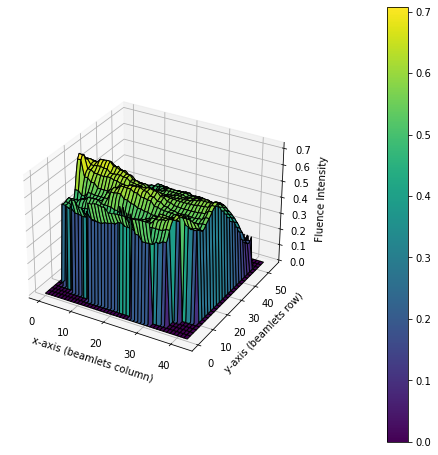

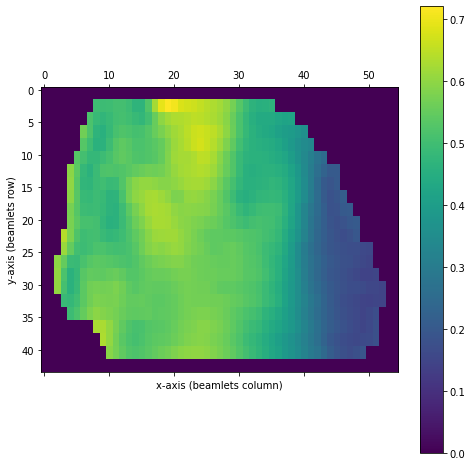

In [4]:
# plot fluence in 3d and 2d
pp.Visualize.plot_fluence_3d(sol=sol, beam_id=37)
pp.Visualize.plot_fluence_2d(sol=sol, beam_id=37)

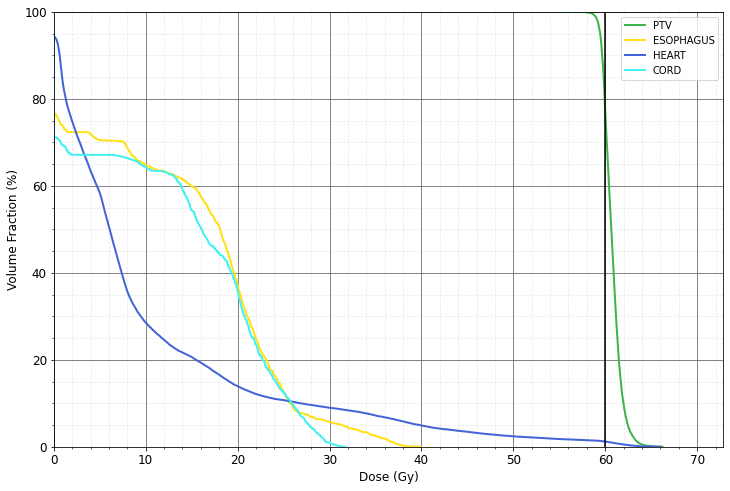

In [9]:
# plot dvh for the structures in the given list. Default dose_1d is in Gy and volume is in relative scale(%).
structs = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']

# visualization methods are exposed using two ways:
# 1. using visualization class
pp.Visualize.plot_dvh(my_plan, sol=sol, structs=structs)

# 2. Using object of class Plan. In this case, one doesnt need to pass the plan object as an argument
# my_plan.plot_dvh(sol=sol, structs=structs)

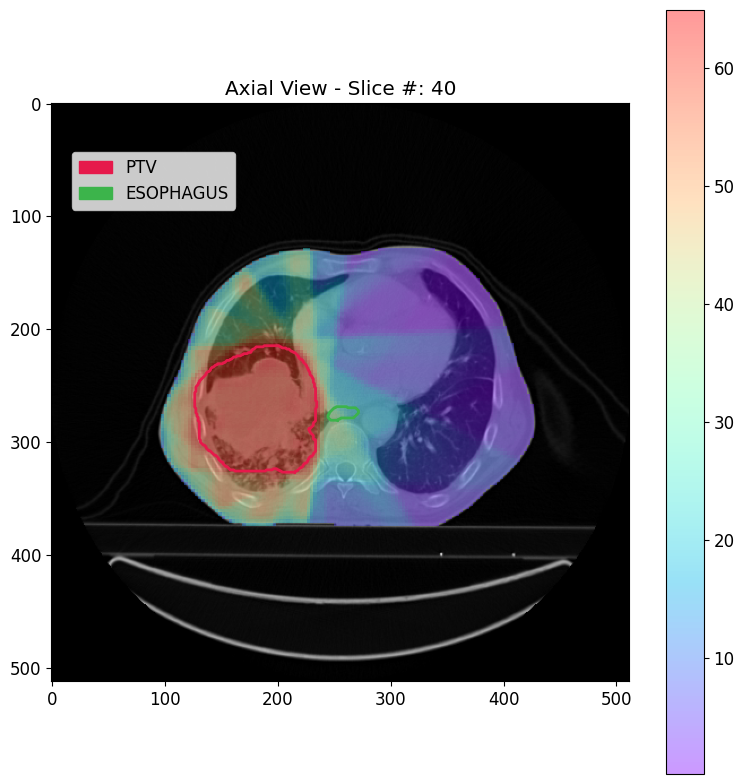

In [13]:
# plot 2d axial slice for the given solution and display the structures contours on the slice
pp.Visualize.plot_2d_dose(my_plan, sol=sol, slice_num=40, structs=['PTV', 'ESOPHAGUS'], show_isodose=False)

In [13]:
# visualize plan metrics based upon clinical criteria
pp.Visualize.plan_metrics(my_plan, sol=sol)

In [15]:
# view ct, dose_1d and segmentations in 3d slicer. This requires downloading and installing 3d slicer
# First save the Nrrd images in data_dir directory
# pp.save_nrrd(my_plan, sol=sol, data_dir=r'C:\temp')
pp.Visualize.view_in_slicer(my_plan, slicer_path=r'C:\ProgramData\NA-MIC\Slicer 4.11.20210226\Slicer.exe',
                            data_dir=r'C:\temp')
print('Done!')

Done
Done!
